### Downloading Dataset 

In [2]:
import os 
from tqdm import tqdm
#from google.colab import drive
import shutil 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot  as plt
from pathlib import Path
import imagesize
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import pandas as pd
import zipfile 
import statistics 
import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir dataset
!cp "gdrive/My Drive/DLL_project/dataset/Adaptiope.zip" dataset/
!ls dataset

Adaptiope.zip


In [ ]:
!unzip dataset/Adaptiope.zip

Streaming output truncated to the last 5000 lines.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png

In [ ]:
! rm -rf adaptiope_small

In [ ]:
! mkdir adaptiope_small

In [4]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

domains = ["product_images", "real_life"]

In [3]:
with zipfile.ZipFile("data/Adaptiope.zip", 'r') as zip_f:
    namelist = zip_f.namelist() 
    images = [x for x in namelist if x.endswith(".jpg")]
    filter = [f"Adaptiope/{y}/{x}/" for y in domains for x in classes]
    cl_images = [x for x in images if x.startswith(tuple(filter))]
    zip_f.extractall(path = "data/", members= cl_images)

## EDA: Exploratory Data Analysis


Firstly, the dimensions of each image have been extracted as saved as metadata within a dictionary. 

In [5]:

metadata_img = {}

for domain in domains:
  subclass = os.listdir(f"data/Adaptiope/{domain}")
  for cls_name in classes:
    imgs = [img.name for img in Path(f"data/Adaptiope/{domain}/{cls_name}/").iterdir() if img.suffix == ".jpg"]
    for img in imgs: 
      metadata_img[str(img + domain)] = imagesize.get(f"data/Adaptiope/{domain}/{cls_name}/"+img)



Secondly, some statistics have been performed on the dimensions in order to find out their average and standard deviation across the dataset. The results are reported below. 

In [6]:
# some statistics to check how many images we have and their dimensions (on average)
img_df = pd.DataFrame.from_dict([metadata_img]).T.reset_index().set_axis(['file_name', 'size'], axis='columns', inplace=False)
img_df[["width", "height"]] = pd.DataFrame(img_df["size"].tolist(), index=img_df.index)
avg_width = round(img_df["width"].sum() / len(img_df))
avg_height = round(img_df["height"].sum() / len(img_df))
sd_width = round(statistics.stdev(img_df["width"]), 2)
sd_height = round(statistics.stdev(img_df["height"]), 2)


print(f'Total images in Adaptiope dataset: {len(img_df)}')
print(f'Average height in Adaptiope dataset: {avg_height}')
print(f'Std height in Adaptiope dataset: {sd_height}')

print(f'Average width in Adaptiope dataset: {avg_width}')
print(f'Std width in Adaptiope dataset: {sd_width}')


Total images in Adaptiope dataset: 4000
Average height in Adaptiope dataset: 1122
Std height in Adaptiope dataset: 415.62
Average width in Adaptiope dataset: 1160
Std width in Adaptiope dataset: 415.42


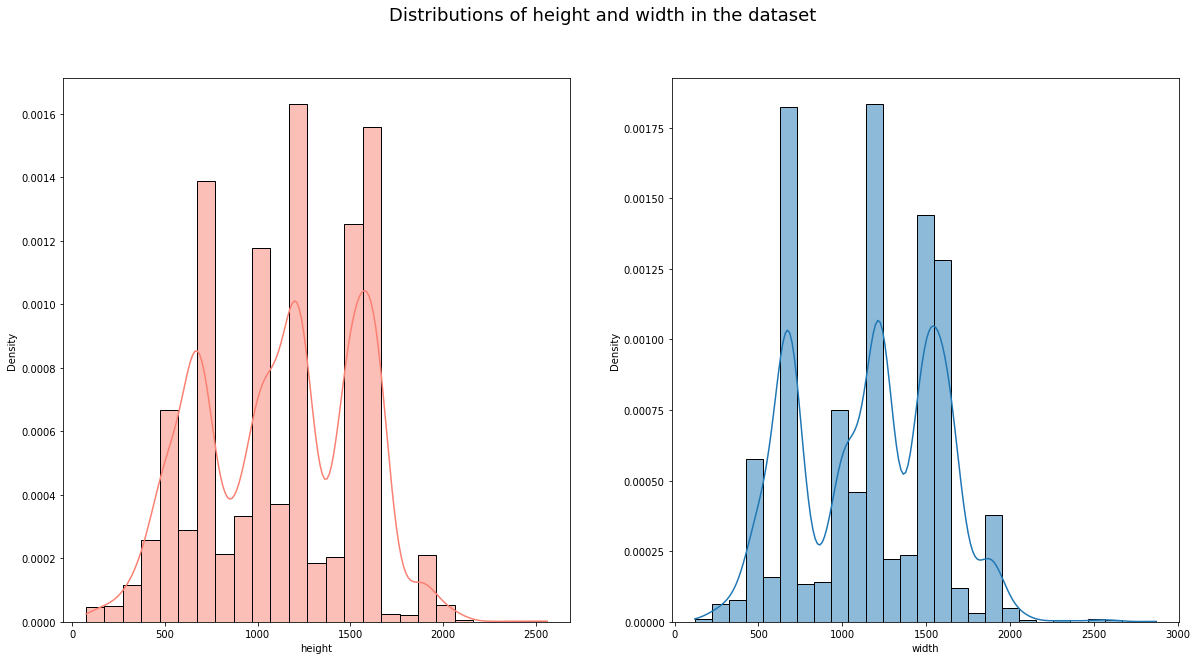

In [23]:


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Distributions of images' height and width in the dataset", fontsize=18)

sns.histplot(data=img_df["height"],
             kde=True, 
             ax = ax1, 
             stat = "density", 
             color="salmon", 
             )

sns.histplot(data=img_df["width"],
             kde=True,
             ax = ax2, 
             stat = "density"
             )

plt.show()

Considering the great standard deviation on both width and height, some further analysis are performed. 

In [7]:
thre = 1e-5 # threshold to check whether images are squared or almost squared
cond = np.logical_and(img_df['height'] - thre < img_df['width'], img_df['width'] < img_df['height'] + thre)
sq_df = img_df[cond]
print('Percentage square images:', len(sq_df.index)/len(img_df.index))

Percentage square images: 0.323


In [8]:
rect_df = img_df[~cond]
avg_size_diff = round(sum(abs(rect_df['width'] - rect_df['height'])) / len(rect_df.index), 2)
std_size_diff = round(statistics.stdev(abs(rect_df['width'] - rect_df['height'])), 2)
print(f'Size difference = {avg_size_diff} +/- {std_size_diff}')

Size difference = 421.57 +/- 258.17


In [9]:
print("Width:", "from", min(img_df["width"]), "to", max(img_df["width"]))
print("Height", "from", min(img_df["height"]), "to", max(img_df["height"]))

Width: from 120 to 2870
Height from 75 to 2560


## Data Transformation

In [10]:
def data_transformation(resize_dim = 256, crop_dim = 224, grayscale = True, crop_center = True):
    
    transform_lst = []
    transform_lst.append(T.Resize((resize_dim)))                                                          
    
    if grayscale:
        transform_lst.append(T.Grayscale(num_output_channels=3))                        
    
    if crop_center:
        transform_lst.append(T.CenterCrop((crop_dim)))
    else:
        transform_lst.append(T.RandomCrop((crop_dim)))
    
    transform_lst.append(T.RandomHorizontalFlip(p=0.5))                                  
    transform_lst.append(T.ToTensor())                                             
        
    return T.Compose(transform_lst)  


In [40]:
def normalization(dataset):
    ds_length = len(dataset)
    for i in tqdm(range(ds_length)):
        r_mean, g_mean, b_mean = torch.mean(dataset[i][0], dim = [1,2])
        r_std, g_std, b_std = torch.std(dataset[i][0], dim = [1,2])
        T.functional.normalize(
            tensor = dataset[i][0], 
            mean = [r_mean, g_mean, b_mean],
            std = [r_std, g_std, b_std],
            inplace=True
            )
    return dataset

In [11]:
source = "product_images"
target = "real_life"
resize_dim = 256
crop_dim = 224
grayscale = False
crop_center = True 


source_ds = torchvision.datasets.ImageFolder(
    root = f"data/Adaptiope/{source}",
    transform = data_transformation(resize_dim, crop_dim, grayscale, crop_center)
    )

target_ds = torchvision.datasets.ImageFolder(
    root = f"data/Adaptiope/{target}",
    transform = data_transformation(resize_dim, crop_dim, grayscale, crop_center)
    ) 

if not grayscale:
    normalization(source_ds)
    normalization(target_ds)
    

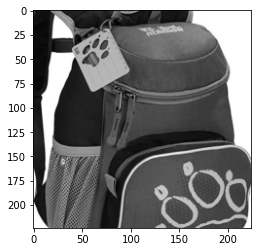

In [12]:
# Check whether the transformations work

inputs, classes = next(iter(source_ds))
plt.imshow(inputs.permute(1, 2, 0))
plt.show()



## Split in train e validation 

Split 80/20

In [13]:
from sklearn.model_selection import train_test_split


def get_data(dataset, test_split = 0.2, batch_size = 32):
    
    # Split dataset into train and validation
    train_indices, val_indices = train_test_split(
        list(range(len(dataset.targets))),
        test_size = test_split,
        stratify = dataset.targets, 
        random_state = 42)
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_data_loader, val_data_loader
    

In [15]:
source_train_loader, source_test_loader = get_data(source_ds)
target_train_loader, target_test_loader = get_data(target_ds)

# Feature extraction 


In [ ]:
model = torchvision.models.resnet18(pretrained=True)

In [ ]:

for param in model.parameters():
    param.requires_grad = False

In [ ]:
features = model.fc.in_features

model.fc = nn.Linear(features, len(dataset.classes))
